In [1]:
# dependencies
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

# How does rainfall in Mangona affect lake level at Bilancino?

What we know:

- The latitude, longitude, and elevation of Mangona, Italy
- The amount of rain that fell each day in Mangona
- The air temperature each day in Le Croci (~7.7km away)
- The level of Lake Bilancino each day (~9.3km away from Mangona)

![mappy](images/mangona-lecroci-bilancino.png)

How *should* we compute this? Using the following equation:

$$
R = P - E - G
$$

where:

- $R$ is surface runoff (ie, how much water went into the lake?)
- $P$ is precipitation (assuming rainfall at Mangona was the only precipitation)
- $E$ is evapotranspiration (how much water went back into the sky?)
- $G$ is groundwater recharge (how much water soaked into the ground?)

## Step 1: Clean Our Data

In [2]:
df = pd.read_csv('data/raw/lake/bilancino.csv')

First, use `Date` as the dataset's index for each row (and make sure it's actually a "date" object, instead of a string or generic "object"):

In [3]:
df.index = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.index.name = None

# make sure to note that the frequency of these dates is daily
df.index.freq = 'D'

# we now no longer need the `Date` column
df = df.drop('Date', axis=1)

Next, confirm that we are not missing any dates

In [4]:
last = None
for current in df.index.values:
    
    # if we're not on the first date in our dataset,
    # then confirm that it is exactly one day ahead
    # of the previous date
    if last is not None:
        
        # create a "time delta" of one day
        td = pd.Timedelta('1D')
        
        # determine what the current time "should" be
        now = last + td
        
        # compare that the current is what it should be
        assert current == now
    
    # before we go on to the next date, save the
    # current one so that we can do this comparison again
    last = current

How many values are missing from the dataset?

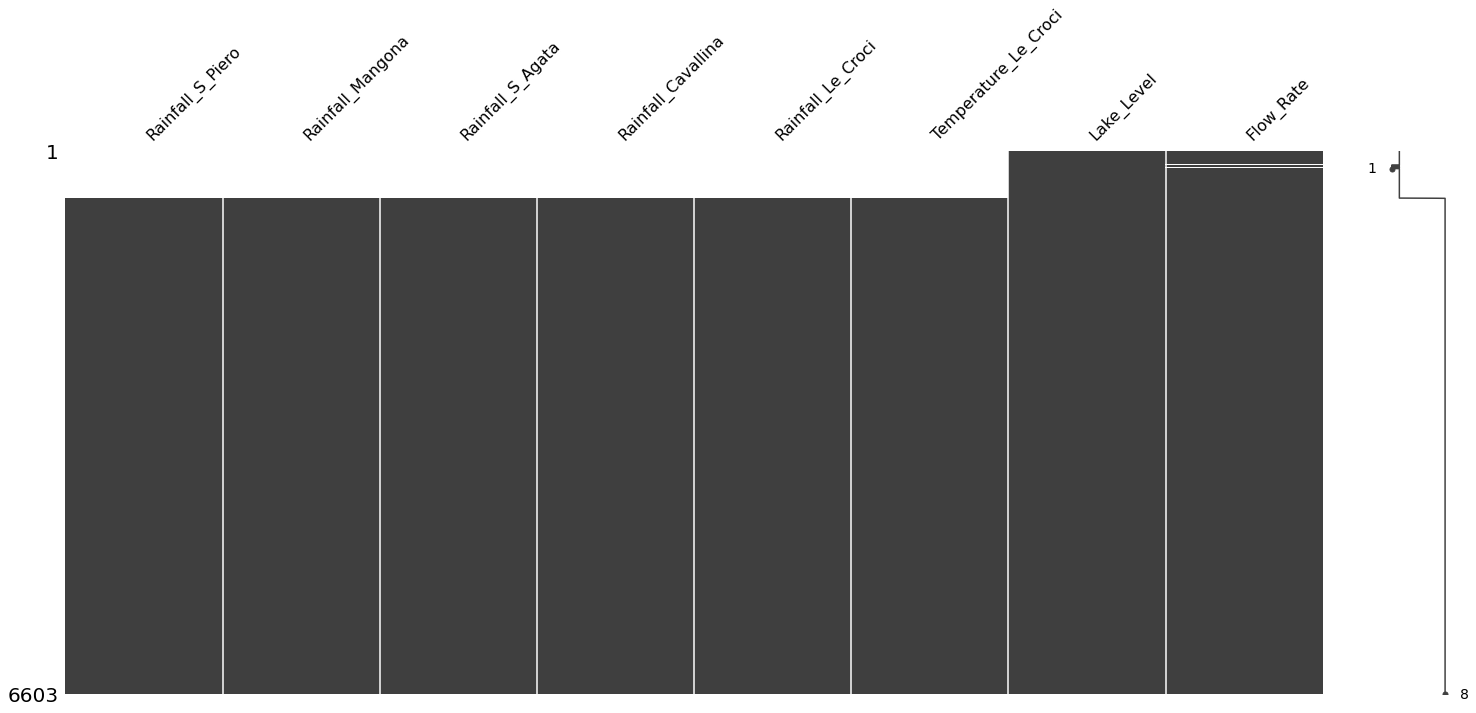

In [5]:
msno.matrix(df)
plt.show()

It looks like we have no non-target data prior to January 2, 2004; let's drop all of those older rows

In [6]:
df = df[df.index > pd.Timestamp('2004-1-1')]

# make sure we no longer have any missing values
assert df.isnull().sum().sum() == 0

Per the dataset description file that was included in the competition, we should only consider the absolute values of the `Rainfall`, `Lake_Level`, and `Flow Rate` columns.

In [7]:
for col in df.columns:
    
    # DON'T take the absolute value of the temperature column
    if col.startswith('Temperature'):
        continue
    
    else:
        df[col] = df[col].abs()

We are only interested in three columns: rainfall at Mangona, temperature at Le Croci, and lake level

In [8]:
df = df[['Rainfall_Mangona', 'Temperature_Le_Croci', 'Lake_Level']]

We now aggregate our data so that we are dealing with everything on a (*calendar*) month-by-month basis

In [9]:
df['Month'] = df.index.month
df['Year'] = df.index.year
df = df.groupby(['Year', 'Month'])

# use the TOTAL rain that fell, but only
# the AVERAGE temperature and lake level for each month
df = pd.DataFrame({
    'Rainfall': df['Rainfall_Mangona'].sum(),
    'Temperature': df['Temperature_Le_Croci'].mean(),
    'Level': df['Lake_Level'].mean()
})

# turn year/month back into columns, instead of row indices
df = df.reset_index()

In [10]:
df.head()

,Year,Month,Rainfall,Temperature,Level
0,2004,1,149.2,4.195000,251.677667
1,2004,2,162.8,6.181034,251.823103
2,2004,3,69.4,8.251613,251.870968
3,2004,4,84.8,12.441667,251.973667
4,2004,5,146.8,14.679032,252.077097


## Step 2: Explore Our Data

![total rainfall each month](images/mangona_monthly.png)

![monthly temperature](images/lecroci_temp_monthly.png)

![lake level all-time](images/level1.png)

![lake level monthly](images/levels2a.png)

## Step 3: Calculate $P$

## Step 4: Calculate E

The [climate-indices](https://climate-indices.readthedocs.io/en/latest/) Python package allows us to use the Thornthwaite method for calculating the potential evapotranspiration index of a given location.

The code required to compute the index is beyond the scope of this notebook (a [GitHub repository](https://github.com/cshields143/bilancino_pet) contains all of the gory details), but to summarize:

- The CSV data we were provided is converted into NetCDF format
- The `climate-indices` package is run from the command line to compute the PET index
- The resulting data, still in NetCDF format, is converted back to CSV

In [75]:
pet = pd.read_csv('data/pet.csv', index_col=0)
pet.head()

,pet
0,6.495313
1,11.845304
2,23.215454
3,47.408356
4,69.193939


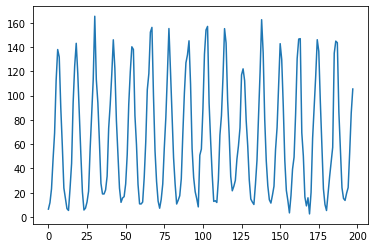

In [76]:
plt.plot(pet['pet'])
plt.show()

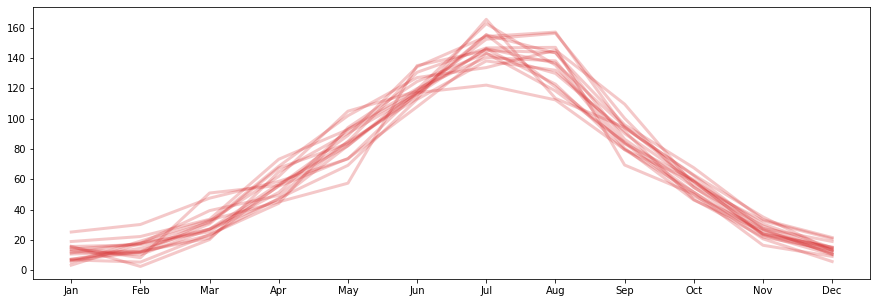

In [88]:
yrs = []
mts = []
for i in pet.index:
    r = df.loc[df.index == i].iloc[0]
    yrs.append(r['Year'])
    mts.append(r['Month'])
pet['Year'] = yrs
pet['Month'] = mts

plt.figure(figsize=(15,5))
for yr in pet['Year'].unique():
    if yr == 2020:
        continue
    vals = pet[pet['Year'] == yr]['pet'].values
    plt.plot(ms, vals, color='C3', linewidth=3, alpha=0.25)
plt.title('Evapotranspiration Is Highest In Summer, Lowest In Winter (2004-2019)', fontweight='bold')
plt.ylabel('')
plt.show()